In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt
import seaborn as sns
import decoupler as dc

In [2]:
# Load the RNA-seq data
rnaseq_df = pd.read_csv('tcga.brca.rnaseq.unstranded.fpkm.counts.matrix (1).txt', sep='\t', index_col=0)

# Load the HRD score data
hrd_df = pd.read_excel('tcga.hrdscore.xlsx')

# Load the BRCA status data
brca_df = pd.read_csv('toga.breast.brca.status.txt', sep='\t', index_col=0)
brca_df.index = brca_df.index.str.replace('.', '-')


In [3]:
# Step 1: Filter for protein coding genes and lncRNA
columns_to_keep = ['Case ID', 'Sample ID', 'Sample Type']
gene_columns = [col for col in rnaseq_df.columns if col not in columns_to_keep]

# Keep both protein coding and lncRNA columns
protein_coding_cols = [col for col in gene_columns if 'protein_coding' in col]
# lncRNA_cols = [col for col in gene_columns if 'lncRNA' in col]

# Combine the columns to keep
final_columns = columns_to_keep + protein_coding_cols

# Filter the DataFrame
rnaseq_df_filtered = rnaseq_df[final_columns]

In [5]:
# Drop rows where event.BRCA1 is '1'
brca_df_filtered = brca_df[brca_df['event.BRCA1'] != '1']

# Drop rows where event.BRCA2 is 'Bi-allelic-undetermined'
brca_df_filtered = brca_df_filtered[brca_df_filtered['event.BRCA2'] != 'Bi-allelic-undetermined']

# Drop rows where event.PALB2 is '2'
brca_df_filtered = brca_df_filtered[brca_df_filtered['event.PALB2'] != '2']

In [6]:
#idenfity the common samples

# Extract sample IDs from each dataframe
rnaseq_samples = set(rnaseq_df['Case ID'])
hrd_samples = set(hrd_df['sample'])
brca_samples = set(brca_df_filtered.index)

# Find the intersection of all sample IDs
common_samples = rnaseq_samples.intersection(hrd_samples).intersection(brca_samples)

# Print the number of common samples
print("\nNumber of common samples:", len(common_samples))



Number of common samples: 857


In [7]:
# Drop samples that are not common in all three dataframes
rnaseq_df_common = rnaseq_df[rnaseq_df['Case ID'].isin(common_samples)]
hrd_df_common = hrd_df[hrd_df['sample'].isin(common_samples)]
brca_df_common = brca_df_filtered[brca_df_filtered.index.isin(common_samples)]

# Print the shapes of the new dataframes
print("rnaseq_df_common:", rnaseq_df_common.shape)
print("hrd_df_common:", hrd_df_common.shape)
print("brca_df_common:", brca_df_common.shape)

rnaseq_df_common: (921, 60663)
hrd_df_common: (857, 5)
brca_df_common: (857, 33)


In [8]:
# duplicates = rnaseq_df_common[rnaseq_df_common['Case ID'].duplicated(keep=False)]
# print("Duplicates in 'Case ID':")
# print(duplicates)
rnaseq_df_common_unique = rnaseq_df_common.drop_duplicates(subset='Case ID', keep='first')
print(rnaseq_df_common_unique.shape)

(857, 60663)


In [9]:
# Step 1: Merge rnaseq_df_common and hrd_df_common
merged_df = pd.merge(rnaseq_df_common_unique, hrd_df_common, 
                     left_on='Case ID', right_on='sample', 
                     how='inner')
print(merged_df.shape)
# Step 2: Merge the result with brca_df_common
final_merged_df = pd.merge(merged_df, brca_df_common, 
                           left_on='Case ID', right_index=True, 
                           how='inner')

# Print the shape of the final merged dataframe
print("Final merged dataframe shape:", final_merged_df.shape)


(857, 60668)
Final merged dataframe shape: (857, 60701)


In [10]:
final_merged_df['BRCA_status'] = final_merged_df.apply(lambda row: 1 if (row['event.BRCA1'] in ['Bi-allelic-inactivation', 'Epigenetic-silencing'] or 
                                                row['event.BRCA2'] in ['Bi-allelic-inactivation', 'Epigenetic-silencing']) 
                                                else 0, axis=1)

In [11]:
final_merged_df['event.TNBC'] = final_merged_df['event.TNBC'].replace({'TNBC': 1, '0': 0})
final_merged_df['Sample Type'] = final_merged_df['Sample Type'].replace({'Primary Tumor': 1, 'Solid Tissue Normal': 0})
final_merged_df = final_merged_df.rename(columns={'Sample Type': 'Tumor Status'})
# final_merged_df = final_merged_df.drop(columns=['Case ID','Sample ID'])
final_merged_df = final_merged_df.drop(columns=['Sample ID'])
final_merged_df = final_merged_df.set_index('Case ID')

# Deconvo
ENIGMA could be a replacemnt for BayesPrism

In [ ]:
import scanpy as sc
import pandas as pd
import scipy.io
import numpy as np

# 1. Load Qian et al. 2020 data and create matrix

# Load the data from the 10x Genomics format
bc_data = sc.read_10x_mtx('./scRNA/BC_counts', var_names='gene_symbols', cache=True)

# Convert the AnnData object to a dense matrix and transpose it
# bc_sc = bc_data.X.toarray() if isinstance(bc_data.X, scipy.sparse.spmatrix) else bc_data.X
# Dont need to transpose for som rsn:
bc_sc = bc_data.to_df()

# 2. Match cell type labels from Qian et al. metadata

# Load metadata with cell type labels
bc_met = pd.read_csv('./scRNA/2103-Breastcancer_metadata.csv.gz')
bc_cellMeta = bc_met['CellType']

# Display a summary of data dimensions to confirm it loaded correctly
print("Data Matrix Shape:", bc_sc.shape)
print("Metadata Shape:", bc_met.shape)
print("Cell Type Labels (First 5):", bc_cellMeta.head())

Data Matrix Shape: (44024, 33694)
Metadata Shape: (44024, 8)
Cell Type Labels (First 5): 0            DC
1        T_cell
2        Cancer
3       Myeloid
4    Fibroblast
Name: CellType, dtype: object


In [9]:
bc_data.to_df()

,RP11-34P13.3,FAM138A,OR4F5,RP11-34P13.7,RP11-34P13.8,RP11-34P13.14,RP11-34P13.9,FO538757.3,FO538757.2,AP006222.2,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231B
sc5rJUQ024_AAACCTGCAACAACCT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sc5rJUQ024_AAACCTGCAAGAAGAG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sc5rJUQ024_AAACCTGGTCTCCACT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sc5rJUQ024_AAACCTGTCAACGAAA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sc5rJUQ024_AAACGGGAGAGTAAGG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sc5rJUQ064_TTTGTCAAGCACCGCT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sc5rJUQ064_TTTGTCAAGCCAGAAC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sc5rJUQ064_TTTGTCAAGGACGAAA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sc5rJUQ064_TTTGTCAGTCTTGTCC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import numpy as np
import pandas as pd

# Filter rows where cell type is "Cancer"
bc_data_cancer = bc_data[bc_met['CellType'] == 'Cancer']

# Calculate the proportion of cells expressing each gene (i.e., where expression > 0)
index_gene_propCancer = np.mean(bc_data_cancer > 0, axis=0)

# Filter genes based on the 2% expression threshold
bc_data = bc_data[:, index_gene_propCancer > 0.02]



# Define gene groups to filter out
gene_groups = ['Rb', 'Mrp', 'other_Rb', 'chrM', 'MALAT1', 'chrX', 'chrY']

# Assuming `gene_names` contains the gene names in bc_data's columns
# This step will filter out columns with gene names that match `gene_groups`
# Adjust this to match how gene names are represented in your data

gene_names = np.array(bc_met.columns)  # Placeholder for gene names
filter_mask = ~np.isin(gene_names, gene_groups)
bc_data_filtered = bc_data[:, filter_mask]

# Display the shape of the filtered matrix
bc_sc_filtered.shape

TypeError: '>' not supported between instances of 'AnnData' and 'int'

: 

In [155]:
bc_bulk = rnaseq_df_filtered.set_index("Case ID").drop(columns='Sample ID')
new_columns = [bc_bulk.columns[0]] + [col.split('|')[1] if '|' in col else col for col in bc_bulk.columns[1:]]
bc_bulk.columns = new_columns
bc_bulk

,Sample Type,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,...,ACTL10,AC119733.1,AC020765.6,AC010980.1,AC004233.4,AL451106.1,AC008763.4,AC006486.3,AL391628.1,AP006621.6
Case ID,,,,,,,,,,,,,,,,,,,,,
TCGA-E9-A1RH,Primary Tumor,1.0276,0.0000,74.2709,1.3816,1.6749,1.4166,5.2410,8.4782,5.9064,...,0.0,0.0,0.0037,0.0582,0.0000,0.0,0.0000,0.0,0.0000,0.1285
TCGA-C8-A26W,Primary Tumor,13.2684,0.1250,37.9298,3.7360,3.1045,2.4799,7.4851,30.4546,4.3523,...,0.0,0.0,0.0000,0.0191,0.0195,0.0,0.0036,0.0,0.0074,0.3801
TCGA-E9-A1RH,Solid Tissue Normal,12.8007,8.4777,21.6363,2.4554,0.5852,2.7533,27.4655,13.6652,6.0568,...,0.0,0.0,0.0000,0.0383,0.0000,0.0,0.0041,0.0,0.0372,0.1064
TCGA-AO-A0JJ,Primary Tumor,14.8681,2.2172,27.8838,4.3170,1.7847,3.7167,9.6630,16.7889,3.6701,...,0.0,0.0,0.0000,0.0313,0.0512,0.0,0.0000,0.0,0.0058,0.2546
TCGA-BH-A0HO,Primary Tumor,0.8430,0.0798,22.1105,3.9971,0.9805,2.4742,3.8185,12.5473,5.9260,...,0.0,0.0,0.0034,0.0088,0.0000,0.0,0.0000,0.0,0.0041,0.4599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-BH-A0AU,Primary Tumor,6.4837,0.7204,37.6328,4.3130,1.9342,1.6600,6.3929,11.7178,2.7094,...,0.0,0.0,0.0109,0.0072,0.0000,0.0,0.0000,0.0,0.0066,0.0886
TCGA-A8-A09G,Primary Tumor,7.6167,0.3250,33.0678,6.5885,2.3227,1.8351,5.2748,14.7306,3.2332,...,0.0,0.0,0.0075,0.0392,0.0000,0.0,0.0000,0.0,0.0121,0.2942
TCGA-E2-A14X,Primary Tumor,20.7009,0.1777,39.0361,6.4451,2.7007,2.9901,5.2498,23.8547,6.6448,...,0.0,0.0,0.0061,1.2138,0.0328,0.0,0.0000,0.0,0.0223,0.1917


In [156]:
bc_data.to_df().columns

Index(['RP11-34P13.3', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8',
       'RP11-34P13.14', 'RP11-34P13.9', 'FO538757.3', 'FO538757.2',
       'AP006222.2',
       ...
       'AC007325.2', 'BX072566.1', 'AL354822.1', 'AC023491.2', 'AC004556.1',
       'AC233755.2', 'AC233755.1', 'AC240274.1', 'AC213203.1', 'FAM231B'],
      dtype='object', length=33694)

In [157]:
bc_data.var_names

Index(['RP11-34P13.3', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8',
       'RP11-34P13.14', 'RP11-34P13.9', 'FO538757.3', 'FO538757.2',
       'AP006222.2',
       ...
       'AC007325.2', 'BX072566.1', 'AL354822.1', 'AC023491.2', 'AC004556.1',
       'AC233755.2', 'AC233755.1', 'AC240274.1', 'AC213203.1', 'FAM231B'],
      dtype='object', length=33694)

In [158]:
bc_bulk = bc_bulk.loc[:, (bc_bulk != 0).any(axis=0)]


In [159]:
# Find duplicate column names in bulk_data
duplicate_columns = bc_bulk.columns[bc_bulk.columns.duplicated()]

# Display the duplicate columns
if not duplicate_columns.empty:
    print("Duplicate columns found:", duplicate_columns.tolist())
else:
    print("No duplicate columns found.")

Duplicate columns found: ['TMSB15B', 'MATR3', 'PDE11A', 'POLR2J3', 'SMIM40']


In [160]:
bc_bulk


,Sample Type,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,...,ELOA3D,PDCD6-AHRR,ELOA3,AC013477.1,AC020765.6,AC010980.1,AC004233.4,AC008763.4,AL391628.1,AP006621.6
Case ID,,,,,,,,,,,,,,,,,,,,,
TCGA-E9-A1RH,Primary Tumor,1.0276,0.0000,74.2709,1.3816,1.6749,1.4166,5.2410,8.4782,5.9064,...,0.0,0.0,0.0,0.0073,0.0037,0.0582,0.0000,0.0000,0.0000,0.1285
TCGA-C8-A26W,Primary Tumor,13.2684,0.1250,37.9298,3.7360,3.1045,2.4799,7.4851,30.4546,4.3523,...,0.0,0.0,0.0,0.0000,0.0000,0.0191,0.0195,0.0036,0.0074,0.3801
TCGA-E9-A1RH,Solid Tissue Normal,12.8007,8.4777,21.6363,2.4554,0.5852,2.7533,27.4655,13.6652,6.0568,...,0.0,0.0,0.0,0.0028,0.0000,0.0383,0.0000,0.0041,0.0372,0.1064
TCGA-AO-A0JJ,Primary Tumor,14.8681,2.2172,27.8838,4.3170,1.7847,3.7167,9.6630,16.7889,3.6701,...,0.0,0.0,0.0,0.0063,0.0000,0.0313,0.0512,0.0000,0.0058,0.2546
TCGA-BH-A0HO,Primary Tumor,0.8430,0.0798,22.1105,3.9971,0.9805,2.4742,3.8185,12.5473,5.9260,...,0.0,0.0,0.0,0.0022,0.0034,0.0088,0.0000,0.0000,0.0041,0.4599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-BH-A0AU,Primary Tumor,6.4837,0.7204,37.6328,4.3130,1.9342,1.6600,6.3929,11.7178,2.7094,...,0.0,0.0,0.0,0.0000,0.0109,0.0072,0.0000,0.0000,0.0066,0.0886
TCGA-A8-A09G,Primary Tumor,7.6167,0.3250,33.0678,6.5885,2.3227,1.8351,5.2748,14.7306,3.2332,...,0.0,0.0,0.0,0.0000,0.0075,0.0392,0.0000,0.0000,0.0121,0.2942
TCGA-E2-A14X,Primary Tumor,20.7009,0.1777,39.0361,6.4451,2.7007,2.9901,5.2498,23.8547,6.6448,...,0.0,0.0,0.0,0.0000,0.0061,1.2138,0.0328,0.0000,0.0223,0.1917


In [161]:
import numpy as np

# Step 1: Identify duplicate column names
duplicate_columns = bc_bulk.columns[bc_bulk.columns.duplicated()].unique()

# Initialize a list to store the positions of columns to drop
columns_to_drop = []

# Step 2: Iterate over each duplicate column name
for col in duplicate_columns:
    # Get indices (positions) of all columns with the same name
    col_positions = np.where(bc_bulk.columns == col)[0]
    
    # Calculate the sum of each duplicate column
    column_sums = bc_bulk.iloc[:, col_positions].sum(axis=0)
    
    # Find the index (position) of the column with the maximum sum
    max_sum_index = column_sums.idxmax()
    
    # Identify positions of columns to drop (all except the one with the max sum)
    positions_to_drop = [pos for pos in col_positions if pos != max_sum_index]
    
    # Add these positions to the list of columns to drop
    columns_to_drop.extend(positions_to_drop)

# Step 3: Drop the columns by positions
# Determine positions to keep
positions_to_keep = [i for i in range(len(bc_bulk.columns)) if i not in columns_to_drop]

# Reassign bc_bulk to include only the columns to keep
bc_bulk = bc_bulk.iloc[:, positions_to_keep]

# Reset the column names if necessary (optional)
bc_bulk.columns = bc_bulk.columns.get_level_values(0)


In [162]:
# Find duplicate column names in bulk_data
duplicate_columns = bc_bulk.columns[bc_bulk.columns.duplicated()]

# Display the duplicate columns
if not duplicate_columns.empty:
    print("Duplicate columns found:", duplicate_columns.tolist())
else:
    print("No duplicate columns found.")

No duplicate columns found.


In [163]:

rnaseq_df_filtered.filter(regex="TMSB15B")


,ENSG00000158427.15|TMSB15B|protein_coding,ENSG00000269226.7|TMSB15B|protein_coding
0,0.0208,0.0235
1,0.0154,0.0139
2,0.0000,0.0265
3,0.0640,0.0304
4,0.0095,0.0043
...,...,...
1226,0.0231,0.0347
1227,0.0079,0.0095
1228,0.0432,0.0195
1229,0.0320,0.0937


ValueError: x and y must be the same size

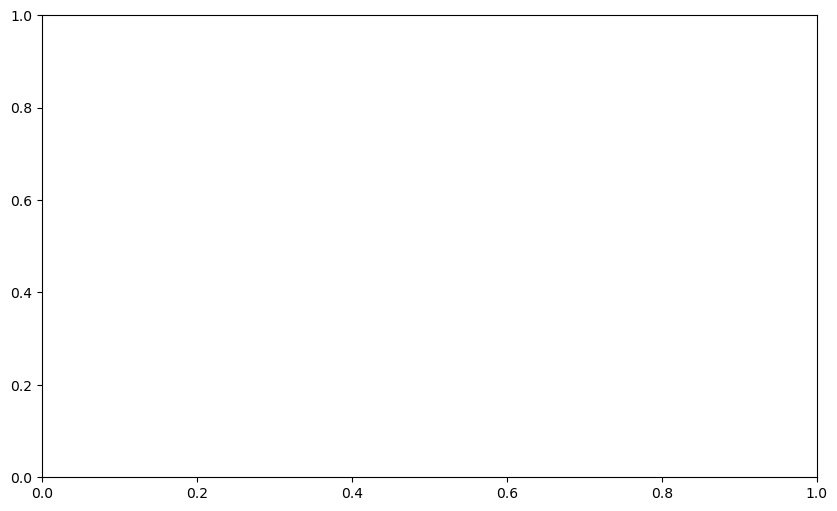

: 

In [ ]:
common_genes = bc_data.var_names.intersection(bc_bulk.columns)
# sc_data = bc_data[:, common_genes].X  # scRNA-seq data
# bulk_data = bc_bulk.loc[common_genes].values  # Bulk RNA-seq data


sc_data = bc_data[:, common_genes].X  # scRNA-seq data for common genes
bulk_data = bc_bulk[common_genes].values  # Bulk RNA-seq data for common genes

sc_mean_expression = np.mean(sc_data, axis=0)

# Plot the bulk vs scRNA-seq gene expression
plt.figure(figsize=(10, 6))
plt.scatter(bulk_data, sc_mean_expression, alpha=0.5)
plt.xlabel("Bulk RNA-seq Expression")
plt.ylabel("Mean scRNA-seq Expression")
plt.title("Concordance of Gene Expression between Bulk and scRNA-seq")
plt.show()


In [122]:
sc_data

<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 66419116 stored elements and shape (44024, 18214)>

In [124]:
# Assuming sc_data is an AnnData object and bc_bulk[common_genes] is a pandas DataFrame

# Get the variable (gene) names from sc_data and convert to a list
sc_var_names = bc_data[:, common_genes].var_names.tolist()

# Get the column names from bc_bulk[common_genes]
bulk_var_names = bc_bulk[common_genes].columns.tolist()

# Sort the variable names alphabetically
sc_var_names_sorted = sorted(sc_var_names)
bulk_var_names_sorted = sorted(bulk_var_names)

# Compare the sorted lists and print differences
for idx, (sc_col, bulk_col) in enumerate(zip(sc_var_names_sorted, bulk_var_names_sorted)):
    if sc_col != bulk_col:
        print(f"Index {idx}: sc_data column '{sc_col}' != bc_bulk column '{bulk_col}'")


Index 8771: sc_data column 'MAU2' != bc_bulk column 'MATR3'
Index 8772: sc_data column 'MAVS' != bc_bulk column 'MAU2'
Index 8773: sc_data column 'MAX' != bc_bulk column 'MAVS'
Index 8774: sc_data column 'MAZ' != bc_bulk column 'MAX'
Index 8775: sc_data column 'MB' != bc_bulk column 'MAZ'
Index 8776: sc_data column 'MB21D2' != bc_bulk column 'MB'
Index 8777: sc_data column 'MBD1' != bc_bulk column 'MB21D2'
Index 8778: sc_data column 'MBD2' != bc_bulk column 'MBD1'
Index 8779: sc_data column 'MBD3' != bc_bulk column 'MBD2'
Index 8780: sc_data column 'MBD3L1' != bc_bulk column 'MBD3'
Index 8781: sc_data column 'MBD3L2' != bc_bulk column 'MBD3L1'
Index 8782: sc_data column 'MBD3L3' != bc_bulk column 'MBD3L2'
Index 8783: sc_data column 'MBD3L4' != bc_bulk column 'MBD3L3'
Index 8784: sc_data column 'MBD3L5' != bc_bulk column 'MBD3L4'
Index 8785: sc_data column 'MBD4' != bc_bulk column 'MBD3L5'
Index 8786: sc_data column 'MBD5' != bc_bulk column 'MBD4'
Index 8787: sc_data column 'MBD6' != bc

In [ ]:
len(common_genes)

18348

/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


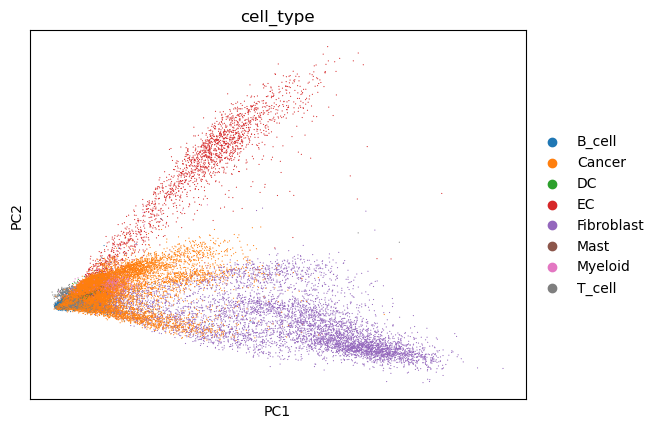

In [24]:
# # 1. Assign cell type labels to the AnnData object
# print(1)
# bc_data.obs['cell_type'] = bc_met['CellType'].values

# # 2. Basic preprocessing - normalization and scaling (commonly done for scRNA-seq)
# print(2)
# sc.pp.normalize_total(bc_data, target_sum=1e4)
# print('2b')
# sc.pp.log1p(bc_data)
# print('2c')
# sc.pp.scale(bc_data, max_value=10)

# # 3. Outlier Detection (optional, based on highly variable genes)
# print(3)
# sc.pp.highly_variable_genes(bc_data, min_mean=0.0125, max_mean=3, min_disp=0.5)
# bc_data = bc_data[:, bc_data.var['highly_variable']]

# # 4. Perform PCA for visualization
# print(4)
# sc.tl.pca(bc_data, svd_solver='arpack')
# sc.pl.pca_scatter(bc_data, color='cell_type', save='_outlier_plot_Qian2020.pdf')

# # Optional: If you want to save as a standalone figure (not embedded in `scanpy` output)
# # plt.savefig('Qian2020_outlierPlot.pdf')
# print(5)
# plt.show()


# 1. Assign cell type labels to the AnnData object
bc_data.obs['cell_type'] = bc_met['CellType'].values

# 2. Basic preprocessing - normalization and log transformation
sc.pp.normalize_total(bc_data, target_sum=1e4)
sc.pp.log1p(bc_data)

# 3. Highly Variable Gene Selection
sc.pp.highly_variable_genes(bc_data, min_mean=0.0125, max_mean=3, min_disp=0.5)
bc_data = bc_data[:, bc_data.var['highly_variable']]

# 4. Convert to dense if still sparse (optional, may use significant memory)
if isinstance(bc_data.X, scipy.sparse.spmatrix):
    bc_data.X = bc_data.X.toarray()

# 5. Scale the data with max_value=10
sc.pp.scale(bc_data, max_value=10)

# 6. Perform PCA for visualization
sc.tl.pca(bc_data, svd_solver='arpack')
sc.pl.pca_scatter(bc_data, color='cell_type', save='_outlier_plot_Qian2020.pdf')

# Optional: If you want to save as a standalone figure
# plt.savefig('Qian2020_outlierPlot.pdf')
plt.show()

In [14]:
import numpy as np

# 1. Filter cells classified as "Cancer"
cancer_cells = bc_data[bc_data.obs['cell_type'] == 'Cancer', :]

# 2. Calculate the proportion of cancer cells in which each gene is expressed (>0)
gene_expression_proportion = np.mean(cancer_cells.X > 0, axis=0)

# 3. Select genes expressed in at least 2% of cancer cells
genes_to_keep = np.array(gene_expression_proportion).flatten() > 0.02
bc_data = bc_data[:, genes_to_keep]

# Display the new shape to confirm filtering
print("Filtered data shape:", bc_data.shape)

Filtered data shape: (44024, 1774)


In [15]:
import scanpy as sc
import pandas as pd
import numpy as np

# Load gene annotation (assuming gene symbols and chromosome info available)
# You may need to download a suitable gene annotation file or use a pre-existing one.
# Here we assume gene annotations are loaded into `gene_annotations` with columns 'gene_symbol' and 'chromosome'

# Placeholder code to load gene annotations - replace with actual loading if available
gene_annotations = pd.DataFrame({
    'gene_symbol': bc_data.var_names,
    'chromosome': ['chrM' if 'MT-' in gene else 'chrX' if 'X-' in gene else 'chrY' if 'Y-' in gene else 'other'
                   for gene in bc_data.var_names]
})

# Add chromosome info to `bc_data` for filtering
bc_data.var['chromosome'] = gene_annotations.set_index('gene_symbol').reindex(bc_data.var_names)['chromosome']

# Identify genes to exclude (Rb, Mrp, mitochondrial genes, etc.)
genes_to_exclude = bc_data.var_names.str.contains(r'Rb|Mrp|chrM|MALAT1|chrX|chrY', case=False, regex=True)
bc_data_filtered = bc_data[:, ~genes_to_exclude]  # Retain only genes not in the exclusion list

# Display the new data dimensions to confirm filtering
print("Filtered data shape:", bc_data_filtered.shape)

Filtered data shape: (44024, 1755)


/var/folders/zc/6j26nlgs3xz5s7v6pjz2b22r0000gn/T/ipykernel_1412/2623745885.py:17: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  bc_data.var['chromosome'] = gene_annotations.set_index('gene_symbol').reindex(bc_data.var_names)['chromosome']


In [16]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np


# # Assuming `bc_sc_filtered` is the filtered single-cell data and `bc_bulk` is the bulk RNA-seq data
# # bc_sc_filtered should be a 2D array or DataFrame with genes in columns and cells in rows
# # bc_bulk should be a 1D array or DataFrame with the bulk RNA-seq expression values for the same genes

# # 1. Aggregate single-cell data by calculating the mean expression across cells for each gene
# sc_gene_means = np.mean(bc_data_filtered.X, axis=0)  # average expression per gene across cells
# sc_gene_means = np.array(sc_gene_means).flatten()  # flatten to 1D array

# # 2. Ensure matching genes between single-cell and bulk data
# common_genes = np.intersect1d(bc_data_filtered.var_names, final_merged_df.index)

# # 3. Filter single-cell and bulk data to include only these common genes
# sc_gene_means_filtered = sc_gene_means[np.isin(bc_data_filtered.var_names, common_genes)]
# bulk_gene_means_filtered = final_merged_df.loc[common_genes].values.flatten()

# # 4. Plot the concordance between scRNA-seq and bulk RNA-seq
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=bulk_gene_means_filtered, y=sc_gene_means_filtered, alpha=0.6)
# plt.xlabel("Bulk RNA-seq Gene Expression")
# plt.ylabel("scRNA-seq Mean Gene Expression")
# plt.title("Concordance Between Bulk and scRNA-seq Gene Expression")
# plt.grid(True)
# plt.show()

In [17]:
bc_cellMeta

0                DC
1            T_cell
2            Cancer
3           Myeloid
4        Fibroblast
            ...    
44019        Cancer
44020        Cancer
44021        Cancer
44022        Cancer
44023        Cancer
Name: CellType, Length: 44024, dtype: object

In [18]:
rnaseq_df

,Case ID,Sample ID,Sample Type,ENSG00000000003.15|TSPAN6|protein_coding,ENSG00000000005.6|TNMD|protein_coding,ENSG00000000419.13|DPM1|protein_coding,ENSG00000000457.14|SCYL3|protein_coding,ENSG00000000460.17|C1orf112|protein_coding,ENSG00000000938.13|FGR|protein_coding,ENSG00000000971.16|CFH|protein_coding,...,ENSG00000288661.1|AL451106.1|protein_coding,ENSG00000288662.1|AC092910.4|lncRNA,ENSG00000288663.1|AC073611.1|lncRNA,ENSG00000288665.1|AC136977.1|lncRNA,ENSG00000288667.1|AC078856.1|lncRNA,ENSG00000288669.1|AC008763.4|protein_coding,ENSG00000288670.1|AL592295.6|lncRNA,ENSG00000288671.1|AC006486.3|protein_coding,ENSG00000288674.1|AL391628.1|protein_coding,ENSG00000288675.1|AP006621.6|protein_coding
0,TCGA-E9-A1RH,TCGA-E9-A1RH-01A,Primary Tumor,1.0276,0.0000,74.2709,1.3816,1.6749,1.4166,5.2410,...,0.0,0.0000,0.0177,0.0,0.0000,0.0000,1.8073,0.0,0.0000,0.1285
1,TCGA-C8-A26W,TCGA-C8-A26W-01A,Primary Tumor,13.2684,0.1250,37.9298,3.7360,3.1045,2.4799,7.4851,...,0.0,0.0000,0.0847,0.0,0.0000,0.0036,3.4634,0.0,0.0074,0.3801
2,TCGA-E9-A1RH,TCGA-E9-A1RH-11A,Solid Tissue Normal,12.8007,8.4777,21.6363,2.4554,0.5852,2.7533,27.4655,...,0.0,0.2708,0.0456,0.0,0.2664,0.0041,5.8816,0.0,0.0372,0.1064
3,TCGA-AO-A0JJ,TCGA-AO-A0JJ-01A,Primary Tumor,14.8681,2.2172,27.8838,4.3170,1.7847,3.7167,9.6630,...,0.0,0.0000,0.0261,0.0,0.0000,0.0000,3.2723,0.0,0.0058,0.2546
4,TCGA-BH-A0HO,TCGA-BH-A0HO-01A,Primary Tumor,0.8430,0.0798,22.1105,3.9971,0.9805,2.4742,3.8185,...,0.0,0.0000,0.0253,0.0,0.0000,0.0000,3.1233,0.0,0.0041,0.4599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226,TCGA-BH-A0AU,TCGA-BH-A0AU-01A,Primary Tumor,6.4837,0.7204,37.6328,4.3130,1.9342,1.6600,6.3929,...,0.0,0.0000,0.1045,0.0,0.0000,0.0000,6.5196,0.0,0.0066,0.0886
1227,TCGA-A8-A09G,TCGA-A8-A09G-01A,Primary Tumor,7.6167,0.3250,33.0678,6.5885,2.3227,1.8351,5.2748,...,0.0,0.0000,0.0485,0.0,0.0000,0.0000,2.8716,0.0,0.0121,0.2942
1228,TCGA-E2-A14X,TCGA-E2-A14X-01A,Primary Tumor,20.7009,0.1777,39.0361,6.4451,2.7007,2.9901,5.2498,...,0.0,0.0000,0.0900,0.0,0.0000,0.0000,5.1344,0.0,0.0223,0.1917
1229,TCGA-HN-A2OB,TCGA-HN-A2OB-01A,Primary Tumor,20.2782,0.6577,18.8827,3.7280,1.0939,1.9115,4.1113,...,0.0,0.0000,0.0813,0.0,0.7234,0.0000,3.3211,0.0,0.0229,0.3809
